# Steps
1. Get Data
2. Clean data (scipy iir filter and lfilter)
    - norch (iirnorch)
    - brandpass (butterworth)
3. group them in to their part using eproach then mean (target how many time non-target how many time)
Test offline
4. use the mean to be X and target-nontarget as y
5. test EM 

In [50]:




# general use
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd

#custom
import sys
sys.path.insert(1, '../utils')
import helper as helper #custom
#calculation
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import math



In [52]:
#Load eeg data and prepare to test
df = pd.read_csv('data/p300-6trials-12rep-chaky.csv')

print(df.shape) #check the size of 0
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz
df.rename(columns={'Unnamed: 1':'P4',
                          'Unnamed: 2':'Pz',
                          'Unnamed: 3':'P3',
                           'Unnamed: 4':'PO4',
                          'Unnamed: 5':'POz',
                           'Unnamed: 6':'PO3',
                          'Unnamed: 7':'O2',
                           'Unnamed: 8': 'O1'
                           
                      }, 
                 inplace=True)

(53328, 10)
(72, 10)
(648, 10)


In [53]:
df.head()

,timestamps,P4,Pz,P3,PO4,POz,PO3,O2,O1,Marker
0,55102.712,43787.426,36719.758,19511.619,47260.172,38144.504,36332.605,24059.730,19694.703,0
1,55102.712,43780.832,36711.020,19499.572,47253.020,38134.625,36320.555,24050.947,19682.455,0
2,55102.713,43788.094,36718.016,19503.305,47263.008,38141.910,36326.344,24061.363,19692.646,0
3,55102.713,43778.371,36705.117,19489.291,47253.285,38129.258,36311.707,24055.416,19674.988,0
4,55102.714,43778.484,36702.750,19484.619,47249.172,38125.461,36304.148,24050.566,19666.764,0


In [54]:
df = df.drop(["timestamps"], axis=1)
df.head()

,P4,Pz,P3,PO4,POz,PO3,O2,O1,Marker
0,43787.426,36719.758,19511.619,47260.172,38144.504,36332.605,24059.730,19694.703,0
1,43780.832,36711.020,19499.572,47253.020,38134.625,36320.555,24050.947,19682.455,0
2,43788.094,36718.016,19503.305,47263.008,38141.910,36326.344,24061.363,19692.646,0
3,43778.371,36705.117,19489.291,47253.285,38129.258,36311.707,24055.416,19674.988,0
4,43778.484,36702.750,19484.619,47249.172,38125.461,36304.148,24050.566,19666.764,0


In [ ]:
raw = helper.df_to_raw(df)
#clean data before use
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()
#according to https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077536,
#the optimal range is 12-18hz

#since we use 6hz, 10hz, and 15hz, 
#we will take five harmonics, which maximum freq is 15 x 5 = 75
#we will take +- 2 at each end, thus 6-2 = 4, and 75+2 = 77

raw.filter(1, 20, method='iir')

raw.plot_psd()

In [62]:
# get only data with marker 1 or 2
select_data = pd.concat([df[df.Marker==1],df[df.Marker==2]])
print(select_data.shape)

X = select_data.drop(["Marker"], axis=1).values
y = select_data.Marker.values
# print(X)
# print(y)
print(X.shape)
print(y.shape)

(720, 9)
(720, 8)
(720,)


LL difference:  92331.30463052866
LL difference:  5.270394928229507
LL difference:  13522.71544076741
LL difference:  2233.9382120047085
LL difference:  938.7999129312957
LL difference:  738.018667603319
LL difference:  483.7235479590454
LL difference:  170.57459490738984
LL difference:  692.8381176739931
LL difference:  955.2243119223422
LL difference:  87.90740097935486
LL difference:  228.0729208844714
LL difference:  381.4894607607275
LL difference:  274.0735652477015
LL difference:  145.60434913776407
LL difference:  101.77913713490125
LL difference:  99.6940989792929
LL difference:  113.96088339156995
LL difference:  130.1142839515378
LL difference:  134.04378405779426
LL difference:  135.26657766179414
LL difference:  147.54559741906996
LL difference:  150.09057446851511
LL difference:  117.99516446255438
LL difference:  66.85490673052846
LL difference:  34.024794800032396
LL difference:  15.549885127969901
LL difference:  3.0431164080946473


Text(0.5, 1.0, 'Final')

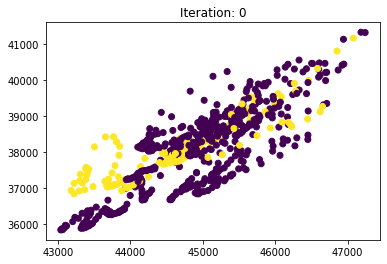

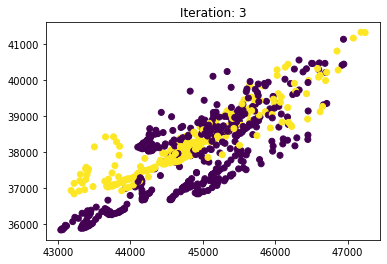

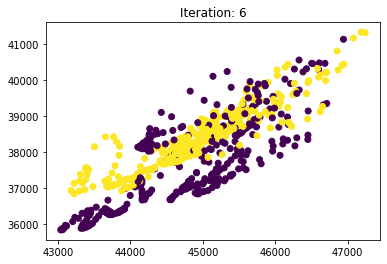

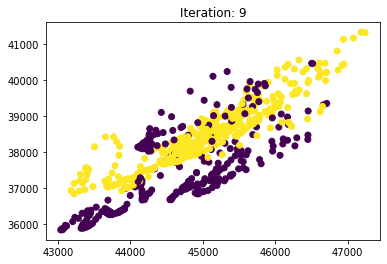

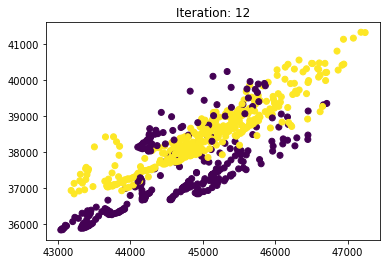

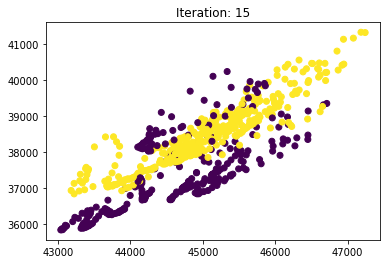

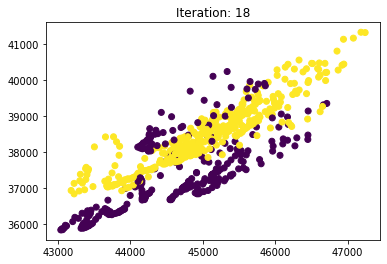

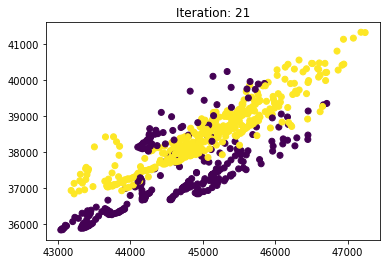

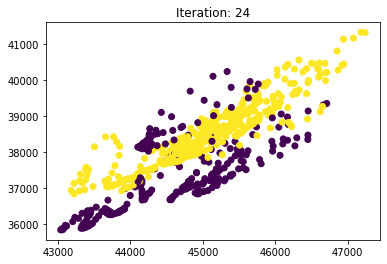

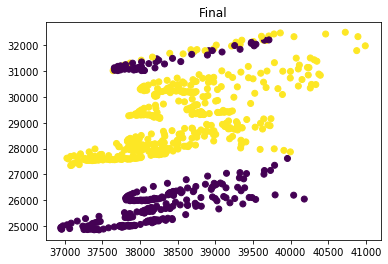

In [64]:
#define basic params
N, M = X.shape
K = 2
max_iter = 50

#old likelihood just for comparison
oldLL = 0

#define gaussian params
#all these params are in vectorized form
#meaning they contain values for all clusters
R = np.full(shape=(N, K), fill_value=1/K)

#simply use 1/k for pi
P = np.full((K, ), fill_value=1/K)

#simply use some rows as mean
random_row = np.random.randint(low=0, high=N, size=K)
MU = np.array([X[idx,:] for idx in random_row ]).T #.T to make to shape (M, K)

#simply use cov of the whole matrix as intialization
SIG = np.array([np.cov(X.T) for _ in range (K)])

for iteration in range(max_iter):
    
    #===E-Step=====
    #Update rc of each sample
    for i in range(N):
        for c in range(K):
            prob_of_xi = multivariate_normal.pdf(X[i], mean=MU[:, c], cov=SIG[c])
            R[i, c] = P[c] * prob_of_xi
        R[i] /= np.sum(R[i])
    
    #calculate log likelihood
    #check for convergence
    #you can delete this part of code, but
    #checking difference in log likelihood is a 
    #good stopping criteria
    LL = 0
    for i in range(N):
        for c in range(K):
            LL += math.log(P[c])
            LL += multivariate_normal.logpdf(
                X[i], mean=MU[:, c], cov=SIG[c])
    
    #if there is less than 0 increase in performance
    #in terms of log likelihood, we stop
    print("LL difference: ", math.fabs(LL - oldLL))
    if(math.fabs(LL-oldLL) < 5):
        break
    oldLL = LL
    
    #every three plot once
    if(iteration % 3 == 0):
        preds = np.argmax(R, axis=1)
        plt.figure()
        plt.scatter(X[:, 0], X[:, 5], c=preds)
        plt.title(f"Iteration: {iteration}")
    
    #===M-Step====
    #mc = sum of all rc
    #MC is vectorized form of all mc
    #Axis = 0 -> sum across all samples
    MC = np.sum(R, axis=0)
    assert MC.shape == (K, )
    
    #P is vectorized form of all pi
    P = MC / N
    assert P.shape == (K, )
    
    #mean
    #each mean is xi * ri / mc
    #MU is vectorized form of all mean
    MU =  ( X.T @ R ) / MC
    assert MU.shape == (M, K)
    
    #covariance (also called Sigma)
    #SIG is vectorized form of all covariances 
    for c in range(K):
        for i in range(N):
            Xmu = (X[i]-MU[:, c]).reshape(-1, 1)
            SIG[c] += R[i, c] * (Xmu @ Xmu.T)
        SIG[c] /= MC[c]
    assert SIG.shape == (K, M, M)
        

#get preds
preds = np.argmax(R, axis=1)

#plot
plt.figure()
plt.scatter(X[:, 4], X[:, 6], c=preds)
plt.title("Final")


In [81]:

pred_res = pd.DataFrame({"pred":preds,"y":y})
print (pred_res)
print(preds)
print(y)


     pred  y
0       0  1
1       0  1
2       0  1
3       0  1
4       0  1
..    ... ..
715     0  2
716     0  2
717     0  2
718     0  2
719     0  2

[720 rows x 2 columns]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [72]:
print(R[1,:])

[1.00000000e+00 2.48358674e-72]


In [ ]:
countData = 0
countSame = 0

for 